## ML Verification – ASO Imagery

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.externals.joblib import load
from sklearn.preprocessing import StandardScaler
import numpy as np

import pandas as pd

from skimage.exposure import equalize_hist as _hist
from skimage.exposure import adjust_sigmoid
from skimage import img_as_ubyte


import rasterio as rio
from rasterio import plot
from rasterio.features import shapes
import cartopy.crs as ccrs
import cartopy.feature as feature

from os import path
from glob import glob
import zipfile
from xml.dom import minidom

import requests
import geopandas as gpd
import pandas as pd
from datetime import timedelta
import rasterio as rio
from rasterio.features import shapes
from rasterio.plot import show
from rasterio.mask import geometry_mask, mask
from shapely.geometry import mapping, shape, Polygon, Point

import seaborn as sns


import numpy as np
import os


%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.dpi'] = 70
plt.rcParams['font.size'] = 19
plt.rcParams['figure.figsize'] = (27, 9)
plt.rcParams['font.size'] = 12

The challenge here is that we've either got totally snow-covered images or totally snow-absent images to test with. That's fine but I guess I'd rather get an image with some mixture. I'll try to extract one for this purpose here. 

## ASO Test Image Choice
We'll grab an image from the melt season. 

In [2]:
YEAR = 2017
asodb = "../data/aso-urls.csv"

asourls = pd.read_csv(asodb, parse_dates=[0]).set_index('date')
asourls.head()


,url
date,
2017-03-03,https://aso.jpl.nasa.gov/_include/new_geotiff/...
2017-04-01,https://aso.jpl.nasa.gov/_include/new_geotiff/...
2016-04-01,https://aso.jpl.nasa.gov/_include/new_geotiff/...
2016-04-07,https://aso.jpl.nasa.gov/_include/new_geotiff/...
2016-06-20,https://aso.jpl.nasa.gov/_include/new_geotiff/...


In [3]:
image = asourls[asourls.index.year == YEAR].loc[pd.datetime(YEAR, 4, 1)]
asoImage = rio.open(image.url)
image_crs = ccrs.epsg(asoImage.crs['init'].split(":")[1])


In [4]:
asoData = asoImage.read(1).astype('float32')
asoData[asoData == -9999] = 0

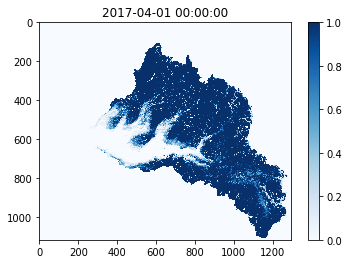

In [5]:
plt.imshow(asoData.astype('float32'), cmap="Blues", vmax=1, vmin=0)
plt.title(image.name)
plt.colorbar()


It seems like the regions to choose are the ones that are on a mid-elevation bands with a pretty wide range of SWE. Let's just pick the satellite images over that region that are closest to those regions. 

In [6]:
geoms = [shape(s[0]) for s in shapes((asoData > 0).astype('int16'), transform=asoImage.transform)]
geoms = gpd.GeoDataFrame(geometry=geoms)
geoms.geometry = geoms.geometry.buffer(0) # self-intersection issues
geoms.crs = asoImage.crs
geoms['id'] = geoms.index
geoms['area'] = geoms.geometry.area
geoms = geoms.sort_values('area', ascending=False)
geoms = geoms.to_crs(ccrs.PlateCarree().proj4_init)
bounds = geoms.cascaded_union.bounds

/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/rasterio/features.py:102: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


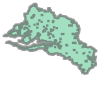

In [7]:
geoms.iloc[1].geometry

### Search Planet for images

In [13]:
from image_utils.search import Search

In [14]:
thisgeom = geoms.iloc[1]
geomidx = thisgeom.name
locgdf = geoms[geoms.index == geomidx]
locgdf['geometry'] = locgdf.geometry.convex_hull
start_date = image.name 
end_date = start_date + timedelta(days=5)
datedf = pd.DataFrame([pd.Series({
    'id' : geomidx, 
    'start_date' : start_date, 
    'end_date' : end_date})])

/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [15]:
s = Search(locgdf, datedf)
results = s.query()
results = gpd.GeoDataFrame(results, geometry=[shape(s) for s in results.geometry])
satframes = results.geometry


Querying Planet API: 100%|██████████| 1/1 [00:02<00:00,  2.80s/searches]


In [16]:
results.head()


,_links,_permissions,geometry,id,properties,type,loc_id
0,{'_self': 'https://api.planet.com/data/v1/item...,"[assets.basic_analytic_rpc_nitf:download, asse...",POLYGON ((-119.5961478736722 37.84839644907922...,20170404_175323_1012,"{'acquired': '2017-04-04T17:53:23.621667Z', 'a...",Feature,0
1,{'_self': 'https://api.planet.com/data/v1/item...,"[assets.basic_analytic_rpc_nitf:download, asse...",POLYGON ((-119.5708618437758 37.93767546527766...,20170404_175322_1012,"{'acquired': '2017-04-04T17:53:22.559379Z', 'a...",Feature,0
2,{'_self': 'https://api.planet.com/data/v1/item...,"[assets.basic_analytic_rpc_nitf:download, asse...",POLYGON ((-119.5523049688479 38.00471396767161...,20170404_175321_1012,"{'acquired': '2017-04-04T17:53:21.497091Z', 'a...",Feature,0
3,{'_self': 'https://api.planet.com/data/v1/item...,"[assets.basic_analytic_rpc_nitf:download, asse...",POLYGON ((-119.5474146722384 38.02241243493358...,20170404_175320_1012,"{'acquired': '2017-04-04T17:53:20.434803Z', 'a...",Feature,0
4,{'_self': 'https://api.planet.com/data/v1/item...,"[assets.basic_analytic_rpc_nitf:download, asse...","POLYGON ((-119.2500303229376 38.0154414550066,...",20170404_175319_1012,"{'acquired': '2017-04-04T17:53:19.372515Z', 'a...",Feature,0


Text(0.5,1,'2017-04-01 00:00:00-2017-04-06 00:00:00')

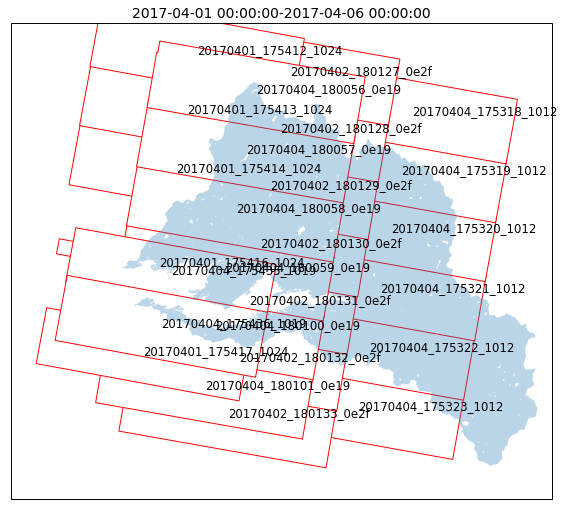

In [17]:
ax = plt.axes(projection=ccrs.UTM(10))
extent = [bounds[0], bounds[2], bounds[1], bounds[3]]
ax.set_extent(extent)
ax.add_geometries(satframes, crs=ccrs.PlateCarree(), facecolor='white', edgecolor='Red')
ax.add_geometries([thisgeom.geometry], crs=ccrs.PlateCarree(), alpha=0.3)
[ax.text(x.geometry.centroid.x, x.geometry.centroid.y, x.id, transform=ccrs.Geodetic()) for id, x in results.iterrows()] 
ax.set_title("{!s}-{!s}".format(start_date, end_date))

Looks like `20170404_175436_1019`

Text(0.5,1,'2017-04-01 00:00:00-2017-04-06 00:00:00')

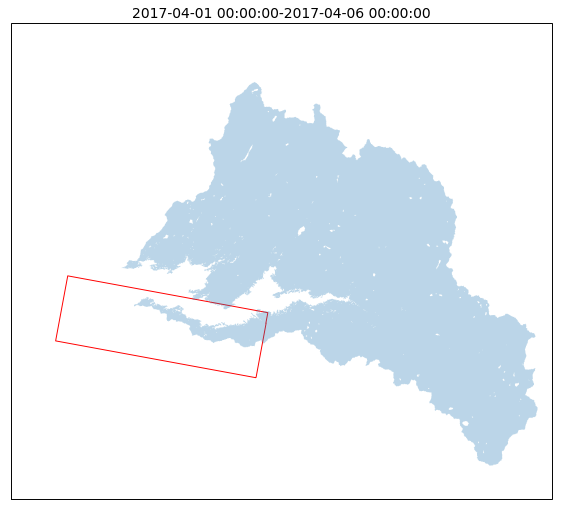

In [18]:
id = "20170404_175436_1019"
thisimage = results[results.id == id]
ax = plt.axes(projection=ccrs.UTM(10))
extent = [bounds[0], bounds[2], bounds[1], bounds[3]]
ax.set_extent(extent)
ax.add_geometries([thisimage.iloc[0].geometry], crs=ccrs.PlateCarree(), facecolor='white', edgecolor='Red')
ax.add_geometries([thisgeom.geometry], crs=ccrs.PlateCarree(), alpha=0.3)

ax.set_title("{!s}-{!s}".format(start_date, end_date))

### Download Image

In [19]:
print(id)

20170404_175436_1019


In [20]:
from image_utils import download
q = download.WholeDownload(0, [id], "../images/ASO")

In [21]:
files = q.run()

Starting activation for image 20170404_175436_1019
querying assets at https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170404_175436_1019/assets/
fetching assets...status:200
Checking url https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170404_175436_1019/assets/
response found.


In [22]:
files = [('../images/ASO/0_20170404_175436_1019.tif', '../images/ASO/0_20170404_175436_1019.xml')]

In [23]:
def openImage(imagef, coeffs=True):   
    image = rio.open(imagef)
    if not coeffs: return(image)
    
    path, base = os.path.split(imagef)
    root = base.split(".")[0]
    meta = minidom.parse(open(os.path.join(path, root + ".xml")))
    nodes = meta.getElementsByTagName("ps:bandSpecificMetadata")

    coeffs = {}
    for node in nodes:
        bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
        if bn in ['1', '2', '3', '4']:
            i = int(bn)
            value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
            coeffs[i] = float(value)
    
    return((image, coeffs))

I think the images we want are basically any of them, but the cropped ones might be good. 

/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


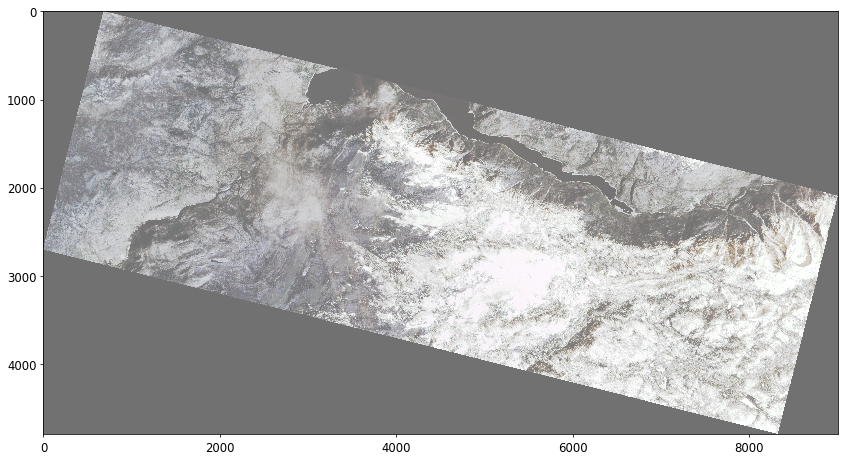

In [24]:
image, coefs = openImage(files[0][0])

b1_toa = image.read(1) * coefs[1]
b2_toa = image.read(2) * coefs[2]
b3_toa = image.read(3) * coefs[3]
b4_toa = image.read(4) * coefs[4]

stack = np.stack([b3_toa, b2_toa, b1_toa], axis=2)

plt.figure(figsize=(20,8))

plt.imshow((img_as_ubyte(np.stack([_hist(stack[:,:,2]), _hist(stack[:,:,1]), _hist(stack[:,:,0])], axis=2))))



/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Text(0.5,1,'20170404_175436_1019')

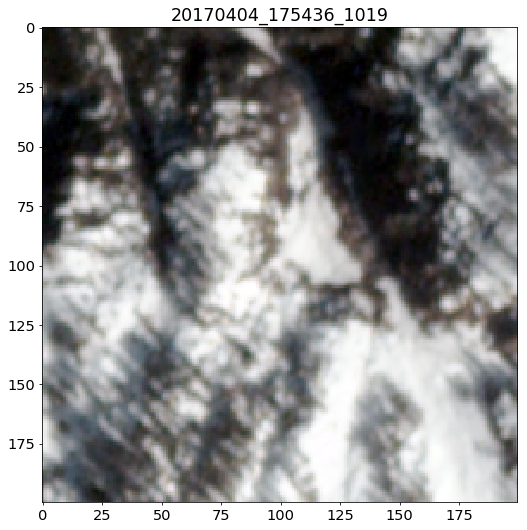

In [43]:
width = 200
startx = 2500
starty = 8000

b1 = image.read(1)[startx:startx+width, starty:starty+width]
b2 = image.read(2)[startx:startx+width, starty:starty+width]
b3 = image.read(3)[startx:startx+width, starty:starty+width]
b4 = image.read(4)[startx:startx+width, starty:starty+width]

teststack = np.stack([b1, b2, b3, b4], axis=2)
teststack
plt.imshow((img_as_ubyte(np.stack([_hist(teststack[:,:,2]), _hist(teststack[:,:,1]), _hist(teststack[:,:,0])], axis=2))))
plt.title(id)

In [32]:
teststack.reshape(-1, 4).shape


(40000, 4)

In [40]:
id

'20170404_175436_1019'

### Do Some Machine Learning

In [33]:
modelfile = "snowcover-model-ASO.pkl"
model = load(modelfile)

In [34]:
predprobs = model.predict_proba(StandardScaler().fit_transform(teststack.reshape(-1, 4)))

/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [35]:
pred =model.predict(StandardScaler().fit_transform(teststack.reshape(-1, 4))).reshape(teststack.shape[:2])


/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [1]:

_pred = predprobs[:,1]

#_pred[(predprobs[:,1] > 0.49) & (predprobs[:,1] < 0.51)] = 1

plt.rcParams['font.size'] = 15

fig, axs = plt.subplots(2,3, figsize=(20,15))
axs[0,0].imshow((img_as_ubyte(np.stack([_hist(teststack[:,:,2]), _hist(teststack[:,:,1]), _hist(teststack[:,:,0])], axis=2))))

axs[0,0].set_title("RGB")

a = axs[0,1].imshow(_pred.reshape(teststack.shape[:2]), cmap='seismic', vmin=0.4, vmax=0.6)
axs[0,1].set_title("$P(snow)$")

a1 = axs[0,2].imshow(pred, cmap='binary_r')
axs[0,2].set_title("Binary Prediction")
cb = plt.colorbar(a, pad=0.05, location='top', use_gridspec=False, ax=axs[1,1])
cb.ax.tick_params(labelsize=14)
cb.set_label("$P(snow)$")


axs[1,0].axis('off')
axs[1,1].axis('off')
axs[1,2].axis('off')

plt.subplots_adjust(hspace=0.02)
plt.tight_layout(h_pad=-10)

plt.savefig("../figures/{}_ASO-{}_{}_{}_allresults.png".format(path.basename(file[0][0]).split(".")[0], id, startx, starty), dpi=200, transparent=True, bbox='tight')

NameError: name 'predprobs' is not defined